## IMPORTING LABRARIES

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Fetching Data and Data Processing


In [14]:

# Load and preprocess the California Housing data
data = fetch_california_housing()

# Convert the data to a DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>,
        <Axes: title={'center': 'AveRooms'}>],
       [<Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'AveOccup'}>],
       [<Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

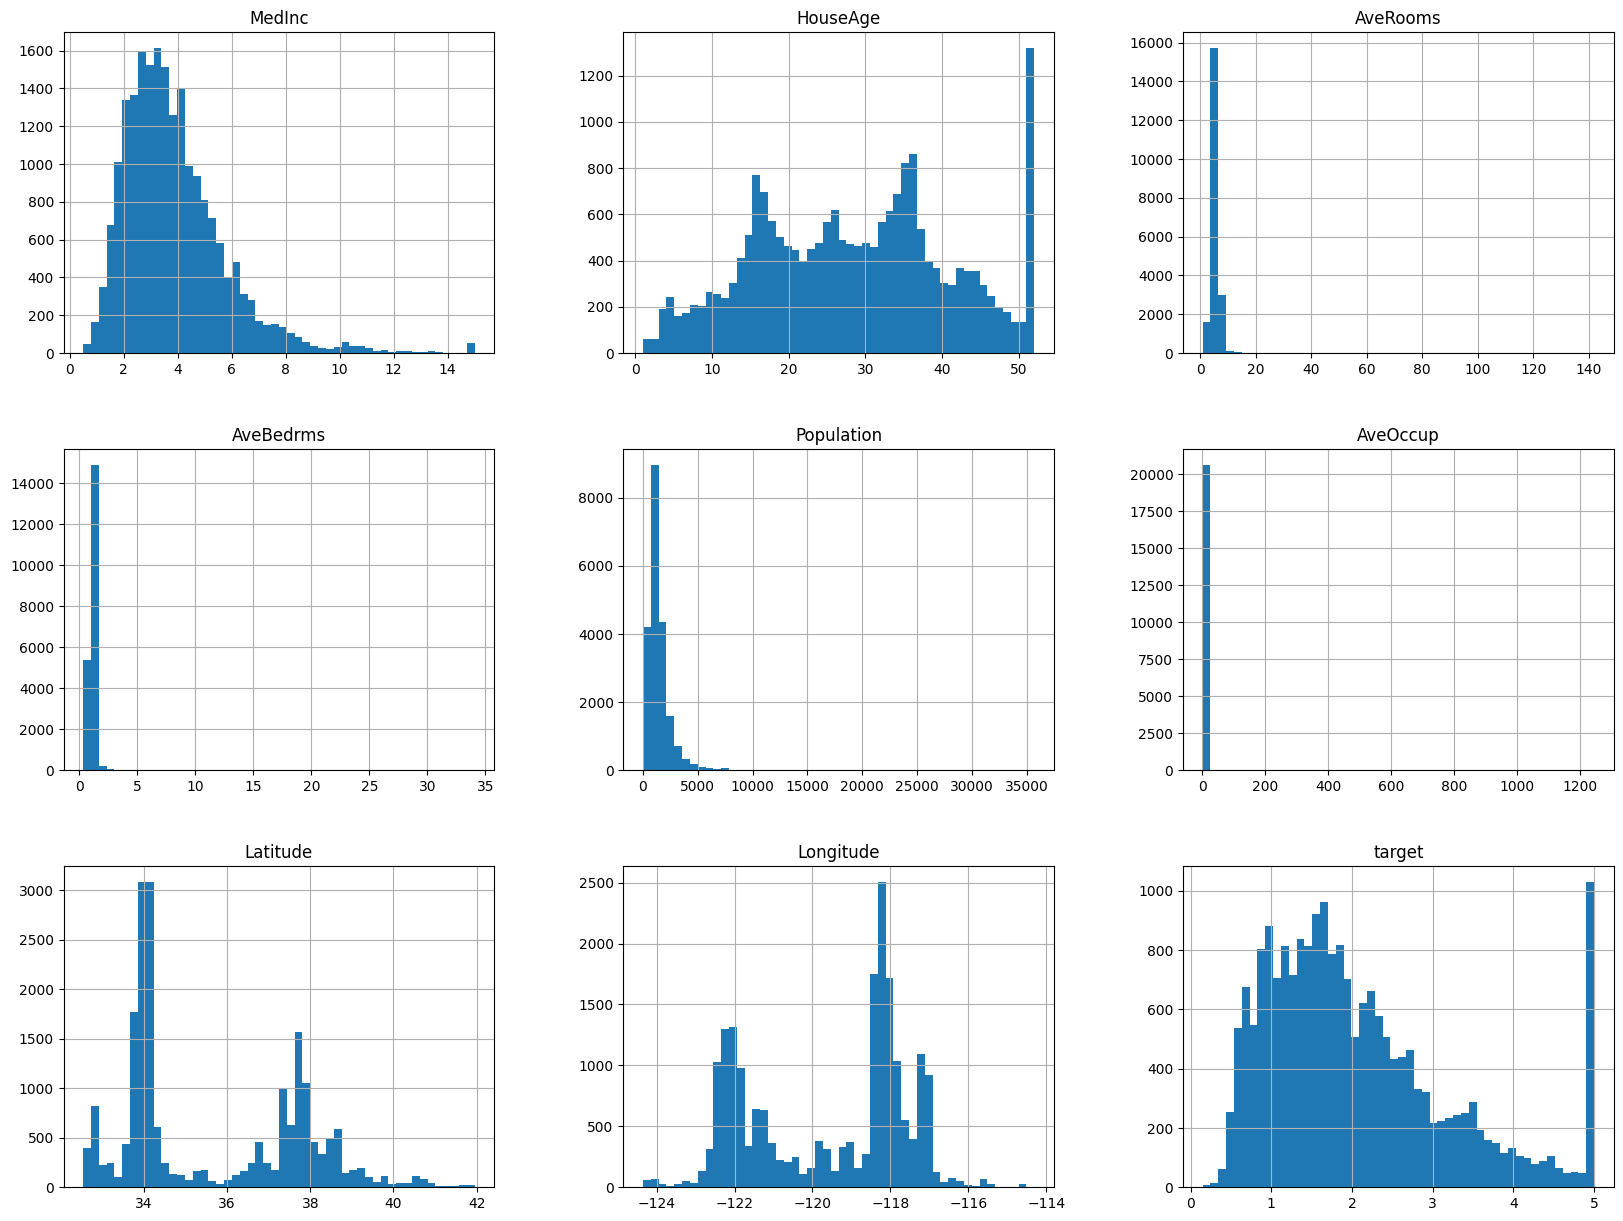

In [28]:
# Plot histograms of the features
df.hist(bins=50, figsize=(20,15)) 

## Cleaning Data

In [ ]:
# nan rows
np.isnan(df).sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

In [ ]:
# infinities rows
np.isinf(df).sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

In [ ]:
#duplicate rows
df.duplicated().sum()

np.int64(0)

- we don't have duplicated or nan or inf values so we can ignore removing them

In [17]:
# Remove all rows where the 'target' column value is greater than 5
data_cleaned = df.loc[df['target'] <= 5]

## Spliting and Scaling Data

In [ ]:
# Split the data into features and target
X, y = data_cleaned.drop('target', axis=1), data_cleaned['target']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Standardize target
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()  # Fit on y_train and transform it

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Class SVM

In [ ]:
# SVM class Definition
class SVM:
    def __init__(self, kernel="rbf", C=1.0, epsilon=0.1, degree=3, gamma=0.5, max_iter=1000, learning_rate=0.001):
        """
        parrameters:
        kernel: str, default="rbf"
            Kernel function to be used in the algorithm. Supported kernels are "linear", "poly", and "rbf".
        C: float, default=1.0
            Regularization parameter. The strength of the regularization is inversely proportional to C.
        epsilon: float, default=0.1
            Tolerance for the optimization problem.
        degree: int, default=3
            Degree of the polynomial kernel function ("poly").
        gamma: float, default=0.5
            Kernel coefficient for "rbf" kernel.
        max_iter: int, default=1000
            Maximum number of iterations for the optimization.
        learning_rate: float, default=0.001
            Learning rate for the gradient descent optimization.

        """
        self.kernel = kernel
        self.C = C
        self.epsilon = epsilon
        self.degree = degree
        self.gamma = gamma
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.alpha = None  # Lagrange multipliers

    # Kernel function
    def _kernel(self, X1, X2):
        """
        Parameters:
        X1: numpy.ndarray
            First input data matrix.
        X2: numpy.ndarray
            Second input data matrix.
        """
        if self.kernel == "linear": # Linear kernel
            return np.dot(X1, X2.T)
        elif self.kernel == "poly": # Polynomial kernel
            return (np.dot(X1, X2.T) + 1) ** self.degree
        elif self.kernel == "rbf": # Radial basis function kernel
            if X1.ndim == 1 and X2.ndim == 1: # 1D array
                return np.exp(-self.gamma * np.linalg.norm(X1 - X2) ** 2)
            elif (X1.ndim > 1 and X2.ndim == 1) or (X1.ndim == 1 and X2.ndim > 1): # 2D array
                return np.exp(-self.gamma * np.linalg.norm(X1 - X2, axis=1) ** 2) 
            elif X1.ndim > 1 and X2.ndim > 1: 
                return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2, axis=2) ** 2)
        else:
            raise ValueError("Unsupported kernel")

    # function to fit the model
    def fit(self, X, y):
        """
        Parameters:
        X: numpy.ndarray
            Input data matrix.
        y: numpy.ndarray
            Target values.
        """

        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples)  # Lagrange multipliers for dual problem
        self.support_vectors = X 
        self.support_labels = y

        # Gradient descent-based optimization
        for _ in range(self.max_iter):
            for i in range(n_samples):
                prediction = self._predict_single(X[i])
                error = y[i] - prediction

                if abs(error) > self.epsilon:
                    self.alpha[i] += self.learning_rate * error

    # function to predict the output for a single input
    def _predict_single(self, x):
        kernel_values = self._kernel(self.support_vectors, x)
        return np.dot(self.alpha, kernel_values)

    # function to predict the output for multiple inputs
    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])

    # function to evaluate the model
    def evaluate(self, X, y, regression=False):
        y_pred = self.predict(X)
        if regression:
            rmse = np.sqrt(np.mean((y - y_pred) ** 2))
            return rmse
        else:
            predictions = np.sign(y_pred)
            accuracy = np.mean(predictions == y)
            return accuracy


## Support Vector Machine (SVM) Mathematical Formulas used in the Code

### 1. **Kernel Functions**
The kernel function computes the similarity between two data points. It maps the data into a higher-dimensional space for classification.

- **Linear Kernel:**
  $$ K(X_1, X_2) = X_1^T X_2 $$

- **Polynomial Kernel:**
  $$ K(X_1, X_2) = (X_1^T X_2 + 1)^\text{degree} $$

- **Radial Basis Function (RBF) Kernel:**
  $$ K(X_1, X_2) = \exp(-\gamma \| X_1 - X_2 \|^2) $$
  Where __| X_1 - X_2 \|__   is the Euclidean distance between the points and __gamma__   is a parameter that controls the spread.

### 2. **Optimization Objective (Primal Form with Gradient Descent)**
I aimed to minimize the error and optimize the Lagrange multipliers __alpha_i__   by updating them iteratively using **gradient descent**. The objective is to minimize the loss function (error) for the given dataset. The update rule for the Lagrange multipliers __alpha_i__   is:

$$
\alpha_i^{(t+1)} = \alpha_i^{(t)} + \eta \cdot (y_i - \hat{y}_i)
$$

- __alpha_i^{(t)__  : The Lagrange multiplier for the \(i\)-th sample at iteration \(t\)
- __eta__  : The learning rate, which controls how much the multiplier is adjusted at each step
- __y_i__  : True label for the \(i\)-th sample
- __hat{y}_i__  : Predicted value for the \(i\)-th sample

The goal is to adjust the Lagrange multipliers so that the predictions __hat{y}_i__   for all samples in the dataset are as close as possible to the true labels __y_i__  . This is done by iteratively updating __alpha_i__   to reduce the error across the dataset.


### 3. **Decision Function (Prediction)**
The decision function is used to make predictions for new data points:

$$
f(X) = \sum_{i=1}^n \alpha_i y_i K(X, X_i) + b
$$
Where:
- __X__  : Test data point
- __X_i__  : Support vectors
- __alpha_i__  : Lagrange multipliers for support vectors
- __y_i__  : Labels of support vectors
- __b__  : Bias term (not implemented in the code)

### 4. **Gradient Descent Update**
The Lagrange multipliers are updated based on the error between the predicted and true labels:

$$
\alpha_i^{(t+1)} = \alpha_i^{(t)} + \eta \cdot (y_i - f(X_i))
$$
- __eta__  : Learning rate
- __y_i__  : True label
- __f(X_i)__  : Predicted value for \(X_i\)

### 5. **Root Mean Squared Error (RMSE)** for Regression
RMSE measures the error between the predicted and actual values:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y_i})^2}
$$
Where:
- __y_i__  : True values
- __hat{y_i}__  : Predicted values
- __n__  : Number of test samples

### 6. **Accuracy (for Classification)**
Accuracy is used when the task is classification (instead of regression):

$$
\text{accuracy} = \frac{1}{n} \sum_{i=1}^n \mathbb{1} (y_i = \hat{y_i})
$$
Where __mathbb{1}(y_i = \hat{y_i})__   is 1 if the prediction is correct, 0 otherwise.


## Training Model

In [ ]:
# Initialize and train the SVM for regression
svm_regressor = SVM(kernel="rbf", C=10.0, epsilon=0.1, gamma=0.1, max_iter=500)
svm_regressor.fit(X_train, y_train) # Fit the model


## Prediction for test data

In [ ]:
# Predict on the test set 
y_pred = svm_regressor.predict(X_test)

## Evaluate Model

In [ ]:
# Evaluate the model
rmse = svm_regressor.evaluate(X_test, y_test, regression=True) # Root Mean Squared Error
mae = np.mean(np.abs(y_test - y_pred)) # Mean Absolute Error
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)) # R2 Score


print("\nRoot Mean Squared Error:", rmse)
print("\nMean Absolute Error:", mae)
print("\nR2 Score:", r2)



Root Mean Squared Error: 0.5639584351038224

Mean Absolute Error: 0.4083163575253903

R2 Score: 0.6954732362338707


## Inverse transform the standardized predictions and target values

In [ ]:
# Inverse transform the standardized predictions and target values
y_pred_original_scale = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_original_scale = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

## Actuel values Vs Predicted values 

In [ ]:
# Create a DataFrame with the actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Values': y_test_original_scale,
    'SVR Predictions': y_pred_original_scale,
    'difference': np.abs(y_test_original_scale-y_pred_original_scale)
})
comparison_df

,Actual Values,SVR Predictions,difference
0,1.042,1.392869,0.350869
1,1.712,2.023157,0.311157
2,0.973,1.978226,1.005226
3,1.027,0.989567,0.037433
4,1.165,1.031274,0.133726
...,...,...,...
3930,4.313,4.207689,0.105311
3931,1.611,2.015973,0.404973
3932,3.250,1.428247,1.821753
3933,1.631,1.887804,0.256804


## Visualizing the actual and predicted values 

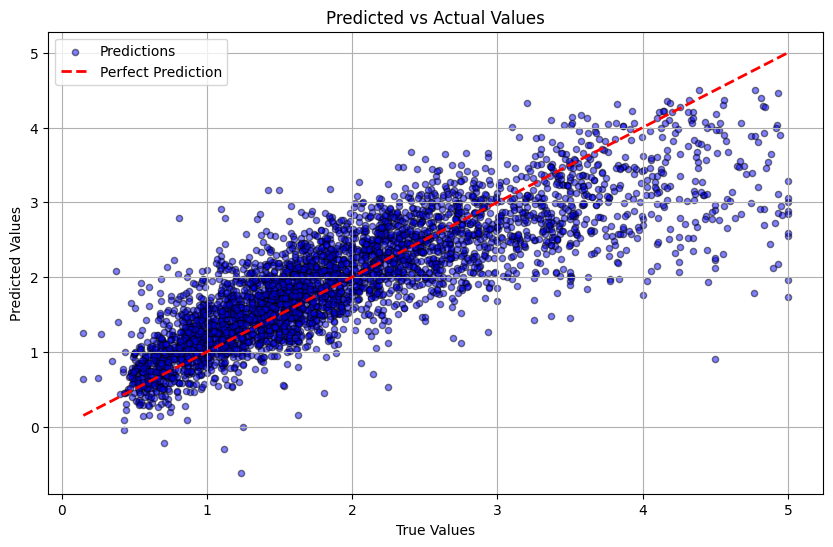

In [ ]:
# Plot the predicted vs actual values for California Housing predictions
def plot_predictions(y_true, y_pred):
    """
    Plots the predicted vs actual values for California Housing predictions.
    
    Parameters:
    - y_true: Array of true target values (actual prices).
    - y_pred: Array of predicted target values from your SVR model.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, color='blue', alpha=0.5, edgecolor='k', s=20, label="Predictions")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2, label="Perfect Prediction")
    
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual Values")
    plt.legend()
    plt.grid(True)
    plt.show()

#plot the predictions
plot_predictions(y_test_original_scale, y_pred_original_scale)


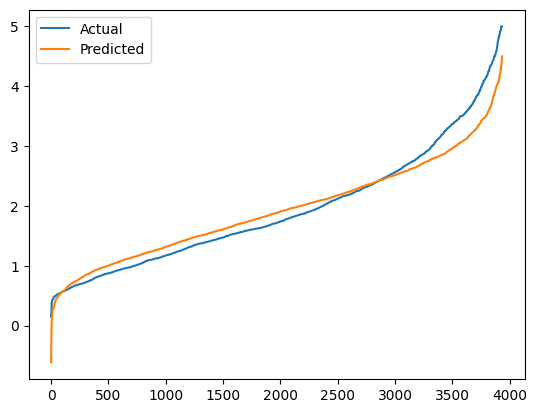

In [ ]:
# Plot the actual and predicted values for the test set in ascending order

y_test_original_scale = sorted(y_test_original_scale)
y_pred_original_scale = sorted(y_pred_original_scale)

plt.plot(y_test_original_scale, label='Actual')
plt.plot(y_pred_original_scale, label='Predicted')
plt.legend()
plt.show()